In [1]:
!pip install transformers[torch] datasets evaluate accelerate sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.7 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.7 MB/s eta 0:00:00


In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
from transformers import T5ForConditionalGeneration, T5Tokenizer, Trainer, TrainingArguments
from datasets import load_dataset
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from wordcloud import WordCloud
from datasets import Dataset as DatasetHF
import sentencepiece
import torch

In [4]:
dataset_sundanese_path = '/content/drive/MyDrive/datasets/cc100/su.txt'
dataset_javanese_path = '/content/drive/MyDrive/datasets/cc100/jv.txt'

def load_dataset_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = file.readlines()
    return data

# Contoh memuat dataset
dataset_sundanese = load_dataset_file(dataset_sundanese_path)
dataset_javanese = load_dataset_file(dataset_javanese_path)

In [5]:
display(dataset_sundanese[300000])
display(dataset_javanese[300000])

'duh…kang jajang nurjaman, tong nyalahkeun wae pemaen kelelahan, jadwal padat jeung sajabana atuh…\n'

'\n'

In [6]:
# Memuat tokenizer dan model
tokenizer = T5Tokenizer.from_pretrained("t5-small")
model = T5ForConditionalGeneration.from_pretrained("t5-small")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Exploratory Datasets

In [7]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

def preprocess_data(data):
    # Basic preprocessing - lowercasing and removing special characters
    return [re.sub(r'\W+', ' ', sentence.lower()) for sentence in data]

def tokenize(data):
    # Splitting each sentence into words
    return [word for sentence in data for word in sentence.split()]

def plot_wordcloud(word_list, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(" ".join(word_list))
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.title(title)
    plt.show()

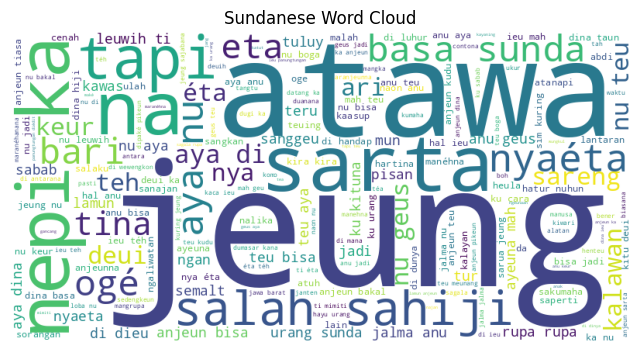

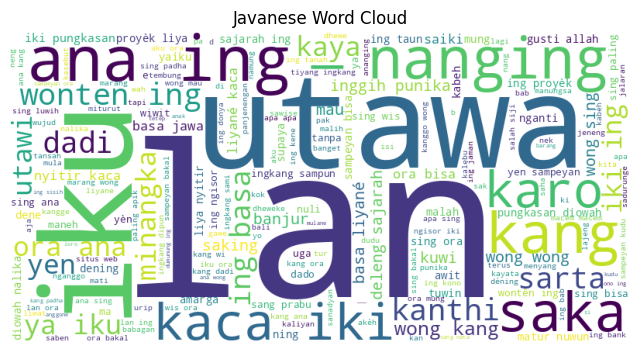

Sundanese:
Most common 10 words: [('nu', 155200), ('jeung', 144216), ('anu', 120012), ('ka', 100481), ('di', 100409), ('dina', 96300), ('ku', 79068), ('teu', 66070), ('anjeun', 66057), ('ieu', 66034)]

Javanese:
Most common 10 words: [('ing', 149417), ('lan', 101946), ('sing', 67811), ('kang', 64528), ('ora', 44236), ('iku', 42325), ('kanggo', 40798), ('iki', 37851), ('ingkang', 37518), ('wong', 34040)]


In [8]:
# Preprocess the data
preprocessed_sundanese = preprocess_data(dataset_sundanese[:300000])
preprocessed_javanese = preprocess_data(dataset_javanese[:300000])

# Tokenize
tokens_sundanese = tokenize(preprocessed_sundanese)
tokens_javanese = tokenize(preprocessed_javanese)

# Generate and plot word cloud
plot_wordcloud(tokens_sundanese, "Sundanese Word Cloud")
plot_wordcloud(tokens_javanese, "Javanese Word Cloud")

# Most common words
def print_most_common(tokens, num=10):
    counter = Counter(tokens)
    most_common = counter.most_common(num)
    print(f"Most common {num} words: {most_common}")

print("Sundanese:")
print_most_common(tokens_sundanese)

print("\nJavanese:")
print_most_common(tokens_javanese)

## Learning Using Sundanese Language Dataset

In [8]:
def preprocess_data(text):
    # Tokenisasi teks
    inputs = tokenizer(text, padding='max_length', truncation=True, max_length=128, return_tensors="pt")

    # Remove the batch dimension
    input_ids = inputs["input_ids"].squeeze()
    attention_mask = inputs["attention_mask"].squeeze()
    # decoder_input_ids = inputs["decoder_input_ids"].squeeze()
    # decoder_attention_mask = inputs["decoder_attention_mask"].squeeze()

    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "decoder_input_ids": input_ids,
        "decoder_attention_mask": attention_mask
    }

In [9]:
encoded_dataset_sundanese = [preprocess_data(text) for text in dataset_sundanese[:300000]]
# encoded_dataset_javanese = [preprocess_data(text) for text in dataset_javanese[:300000]]

In [10]:
dataset_sundanese_df = pd.DataFrame(encoded_dataset_sundanese)
# dataset_javanese_df = pd.DataFrame(encoded_dataset_javanese)
print(dataset_sundanese_df['input_ids'].iloc[0].shape)

# Membuat objek Dataset
hf_dataset_sundanese = DatasetHF.from_dict(dataset_sundanese_df)
# hf_dataset_javanese = DatasetHF.from_dict(dataset_javanese_df)

torch.Size([128])


In [11]:
display(hf_dataset_sundanese)
# display(hf_dataset_javanese)

Dataset({
    features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'],
    num_rows: 300000
})

In [12]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./t5-finetuned-cc100-sundanese",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=10_000,
    save_total_limit=2,
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset_sundanese
)

# Define a custom training step to return None
def custom_training_step(model, inputs):
    return torch.tensor(0.0, requires_grad=True)

trainer.compute_loss = custom_training_step

# Mulai pelatihan
trainer.train()

Step,Training Loss
500,0.000000
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.000000
4500,0.000000
5000,0.000000


TrainOutput(global_step=56250, training_loss=0.0, metrics={'train_runtime': 616.7113, 'train_samples_per_second': 1459.354, 'train_steps_per_second': 91.21, 'total_flos': 3.04519053312e+16, 'train_loss': 0.0, 'epoch': 3.0})

In [13]:
trainer.save_model("/content/drive/MyDrive/Models/T5-small-CC100-SU-02")

## Learning Using Javanese Language Dataset



In [14]:
model = T5ForConditionalGeneration.from_pretrained("/content/drive/MyDrive/Models/T5-small-CC100-SU-02")

In [15]:
# Mengonversi ke Hugging Face Dataset
encoded_dataset_javanese = [preprocess_data(text) for text in dataset_javanese[:300000]]

In [16]:
dataset_javanese_df = pd.DataFrame(encoded_dataset_javanese)
print(dataset_javanese_df['input_ids'].iloc[0].shape)

# Membuat objek Dataset
hf_dataset_javanese = DatasetHF.from_dict(dataset_javanese_df)

torch.Size([128])


In [ ]:
dataset_javanese_df[:300000]

,input_ids,attention_mask,decoder_input_ids,decoder_attention_mask
0,"[tensor(7847), tensor(1212), tensor(12117), te...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(7847), tensor(1212), tensor(12117), te...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,"[tensor(480), tensor(8654), tensor(3), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(480), tensor(8654), tensor(3), tensor(...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,"[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t..."
3,"[tensor(3594), tensor(3181), tensor(9), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(3594), tensor(3181), tensor(9), tensor...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,"[tensor(4848), tensor(11315), tensor(35), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(4848), tensor(11315), tensor(35), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
...,...,...,...,...
299995,"[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t..."
299996,"[tensor(5185), tensor(180), tensor(5115), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5185), tensor(180), tensor(5115), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
299997,"[tensor(5185), tensor(180), tensor(5115), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t...","[tensor(5185), tensor(180), tensor(5115), tens...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
299998,"[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t...","[tensor(1), tensor(0), tensor(0), tensor(0), t..."


In [17]:
hf_dataset_javanese

Dataset({
    features: ['input_ids', 'attention_mask', 'decoder_input_ids', 'decoder_attention_mask'],
    num_rows: 300000
})

In [18]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./t5-finetuned-cc100-sundanese-javanese",
    num_train_epochs=3,
    per_device_train_batch_size=16,
    save_steps=10_000,
    save_total_limit=2,
)

# Inisialisasi Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=hf_dataset_javanese
)

# Define a custom training step to return None
def custom_training_step(model, inputs):
    return torch.tensor(0.0, requires_grad=True)

trainer.compute_loss = custom_training_step

# Mulai pelatihan
trainer.train()

Step,Training Loss
500,0.000000
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.000000
4500,0.000000
5000,0.000000


Step,Training Loss
500,0.000000
1000,0.000000
1500,0.000000
2000,0.000000
2500,0.000000
3000,0.000000
3500,0.000000
4000,0.000000
4500,0.000000
5000,0.000000


TrainOutput(global_step=56250, training_loss=0.0, metrics={'train_runtime': 621.1619, 'train_samples_per_second': 1448.898, 'train_steps_per_second': 90.556, 'total_flos': 3.04519053312e+16, 'train_loss': 0.0, 'epoch': 3.0})

In [19]:
trainer.save_model("/content/drive/MyDrive/Models/T5-small-CC100-SU-JV-02")